In [1]:
!pip install transformers

In [2]:
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


In [3]:
from transformers import pipeline
from transformers import AutoTokenizer,AutoModel
import pandas as pd
import numpy as np

# Load sentences with candidates

In [4]:
df = pd.read_csv('/content/linking_train_with_cands.tsv',sep='\t')
df.head(3)

,article_id,sentence_pos,sentence,mention_pos,mention,wkdt_qid,mention_start,mention_end,wkdt_cands
0,10813493,1,INDIA.,0,INDIA,Q668,0,5,{'INDIA': ['Q668']}
1,10813493,2,"Calcutta, Aug. 3.",1,Calcutta,Q1348,0,8,"{'Calcutta': ['Q1348', 'Q5100141', 'Q2035004',..."
2,10813493,4,The Lieutenant-Governor left Calcutta on the 2...,2,Calcutta,Q1348,29,37,"{'Calcutta': ['Q1348', 'Q5100141', 'Q2035004',..."


# Extract vectors for target expression

In [5]:
model_name = 'distilbert-base-uncased'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
fe = pipeline('feature-extraction',
              model=model,
              tokenizer=tokenizer)

In [ ]:
def get_vector(row,pipeline,tokenizer,agg=np.mean):
    tokenized = tokenizer(row.sentence)

    start_token = tokenized.char_to_token(row.mention_start)

    end_token = tokenized.char_to_token(row.mention_end-1)
    if not end_token:
      print(row.mention) # issue with these names, check later
      end_token = start_token
    tokens_positions = list(range(start_token,end_token+1))
    vectors = np.array(pipeline(row.sentence))
    vector = agg(vectors[0,tokens_positions,:],axis=0)
    return vector

df['vector'] = df.apply(get_vector,pipeline=fe,tokenizer=tokenizer,axis=1)

ASHTON-UNDER-LYNE
DENTON
NEWTON HEATH


# Load gazetteer

In [ ]:
!unzip wikidata_gazetteer.csv.zip

In [ ]:
gazetteer = pd.read_csv('wikidata_gazetteer.csv')


In [12]:
from ast import literal_eval
def eval_with_exception(string):
    try:
        return literal_eval(string)
    except ValueError:
        return None
gazetteer['instance_of'] = gazetteer['instance_of'].apply(eval_with_exception)

In [38]:
gazetteer.columns

Index(['wikidata_id', 'english_label', 'instance_of', 'description_set',
       'alias_dict', 'nativelabel', 'population_dict', 'area', 'hcounties',
       'date_opening', 'date_closing', 'inception_date', 'dissolved_date',
       'follows', 'replaces', 'adm_regions', 'countries', 'continents',
       'capital_of', 'borders', 'near_water', 'latitude', 'longitude',
       'wikititle', 'geonamesIDs', 'connectswith', 'street_address',
       'street_located', 'postal_code'],
      dtype='object')

# Load embeddings of the wikidata classes

In [15]:
wiki_classes = open('wikidata_ids.txt','r').read().split('\n')
wiki_classes[:3]

['Q150093', 'Q79696253', 'Q8038600']

In [17]:
embeddings = np.load('embeddings.npy')
print(embeddings.shape,len(wiki_classes))

(9915, 128) 9915


# Create network data

In [19]:
df.iloc[2]

article_id                                                10813493
sentence_pos                                                     4
sentence         The Lieutenant-Governor left Calcutta on the 2...
mention_pos                                                      2
mention                                                   Calcutta
wkdt_qid                                                     Q1348
mention_start                                                   29
mention_end                                                     37
wkdt_cands       {'Calcutta': ['Q1348', 'Q5100141', 'Q2035004',...
vector           [0.3800719380378723, -0.5807441473007202, -0.1...
Name: 2, dtype: object

In [26]:
df['wkdt_cands'] = df['wkdt_cands'].apply(eval_with_exception)

In [34]:
def get_all_wiki_ids(df):
  ids = set()
  for i,row in df.iterrows():
    ids.add(row.wkdt_qid)
    for k,v in row.wkdt_cands.items():
      ids.update(set(v))
  return dict(zip(range(len(ids)),sorted(ids)))

idx2wikidata = get_all_wiki_ids(df)
wikidata2idx = {j:i for i,j in idx2wikidata.items()}


In [181]:
from itertools import combinations
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from scipy.spatial.distance import pdist, squareform
from math import radians, cos, sin, asin, sqrt
from tqdm import tqdm_notebook

In [209]:
def create_x(row,candidate):
  instance_ids = gazetteer[gazetteer.wikidata_id==candidate].instance_of.values[0]
  if not instance_ids: # if not instance ids, quicks hack refine later
    instance_ids = ['Q000000000000']
  embedding_vectors = []
  for i in instance_ids:
    try:
      embedding_vectors.append(embeddings[wiki_classes.index(i)])
    except:
      continue
  if not embedding_vectors:
    avg_vector = np.random.uniform(low=-1.0, high=1.0, size=(1,128))[0] # generate random vector in case not instance embedding
  
  else: avg_vector = np.mean(np.array(embedding_vectors),axis=0)
  return np.concatenate([avg_vector, row.vector], axis=None,dtype=np.float64)

# taken from https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points

def get_distance(v1,v2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    lon1, lat1 = v1
    lon2, lat2 = v2
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [210]:
def create_network_from_row(row,start_idx=0):
  candidates_ids = set()
  for k,v in row.wkdt_cands.items():
      candidates_ids.update(set(v))
  candidates = gazetteer[gazetteer.wikidata_id.isin(candidates_ids)][['wikidata_id','longitude','latitude']]
  candidates.reset_index(inplace=True,drop=True)
  
  # create labels
  candidates['y'] = 0
  candidates.loc[candidates.wikidata_id==row.wkdt_qid,'y'] = 1

  # add vector representation


  class_embeddings = []
  for i,candidate in candidates.iterrows():
    class_embeddings.append(create_x(row,candidate.wikidata_id))
  candidates['x'] = class_embeddings

  # create nodes from dataframe
  nodes = []
  for n_id,cand_row in cands.iterrows():
    nodes.append((n_id+start_idx,{"y": cand_row.y,
                        'x': cand_row.x})) 
    
  
  # compute edge weights which is 1 / distance between entitities
  distances = pdist(candidates[['longitude','latitude']].values, metric=get_distance)
  dist_matrix = squareform(distances)
  one_over_dist = 1 / dist_matrix

  # create edges based on distance between all nodes

  combs = combinations(candidates.index,2)

  edges = []
  for s,e in combs:
    distance = one_over_dist[s,e]
    edges.append((s+start_idx,e+start_idx,distance))

  
  return nodes,edges


In [211]:
df.shape

(2772, 10)

In [242]:

nodes_all,edges_all = [],[]
#for i,row in tqdm_notebook(df[:10].iterrows()):

row = df.iloc[2]
n,e = create_network_from_row(row, start_idx=len(nodes_all))
nodes_all.extend(n)
edges_all.extend(e)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [243]:
for ids,n_dict in nodes_all:
  #print(n_dict.keys())
  if not n_dict['x'].dtype == np.float64:
    print(n_dict)
  if not isinstance(n_dict['x'],np.ndarray):
    print(n_dict)
  if not isinstance(n_dict['y'],int):
    print(n_dict)

In [244]:
# create the network from nodes and edges
G = nx.Graph()
G.add_nodes_from(nodes_all)
G.add_weighted_edges_from(edges_all)
#data =  from_networkx(G)

In [245]:
G.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16

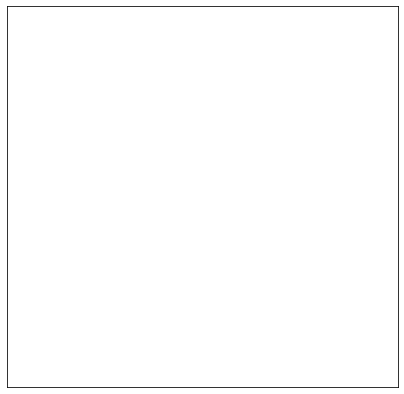

In [246]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False)
plt.show()

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


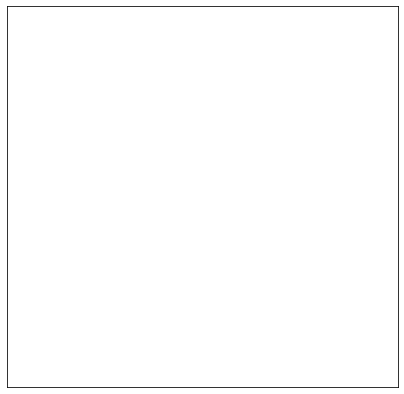

In [219]:
#G = to_networkx(data, to_undirected=True)
import matplotlib.pyplot as plt
def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


visualize_graph(G)

In [195]:
data

Data(x=[210, 896], edge_index=[2, 2302], y=[210], weight=[2302])

In [176]:
# Train classifier

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


AttributeError: ignored

In [96]:


row = df.iloc[10]
cands = create_network(row)
cands.reset_index(inplace=True,drop=True)
cands['y'] = 0
cands.loc[cands.wikidata_id==row.wkdt_qid,'y'] = 1
cands


,wikidata_id,longitude,latitude,y
0,Q891827,72.833333,18.966667,0
1,Q891832,175.021992,-37.210781,0
2,Q16911855,72.835500,18.939800,0
3,Q3634490,72.850000,18.960000,0
4,Q3708546,-74.567778,44.938889,0
5,Q827761,72.891110,19.136670,0
6,Q2627082,72.825833,18.975000,0
7,Q14705729,-74.074000,40.735400,0
8,Q1156,72.877393,19.075990,1
9,Q7373829,72.800000,18.966667,0


In [137]:

create_x(row,'Q891832').shape

(896,)

In [149]:
distances = pdist(cands[['longitude','latitude']].values, metric=get_distance)
dist_matrix = squareform(distances)
one_over_dist = 1 / dist_matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
list(cands.wikidata_id).index('Q4786546')

13

In [152]:


edges = []
for s,e in combs:
  #i = list(cands.wikidata_id).index(s)
  #j =  list(cands.wikidata_id).index(e)
  distance = one_over_dist[s,e]
  #edges.append((wikidata2idx[s],wikidata2idx[e],distance))
  edges.append((s,e,distance))
edges

[(0, 1, 8.114526349360608e-05),
 (0, 2, 0.33376123282967685),
 (0, 3, 0.5254762753032891),
 (0, 4, 8.210315199905772e-05),
 (0, 5, 0.0503653594051801),
 (0, 6, 0.8218405895663776),
 (0, 7, 7.969452999371931e-05),
 (0, 8, 0.0768718603086879),
 (0, 9, 0.28528809217652695),
 (0, 10, 0.07121372027991626),
 (0, 11, 0.0684467048282149),
 (0, 12, 0.2326635479907654),
 (0, 13, 0.2540833513535203),
 (0, 14, 0.306885371012819),
 (0, 15, 0.3136974840860559),
 (0, 16, 0.25270489329389534),
 (0, 17, 0.0009713449307405488),
 (0, 18, 0.04885167271626792),
 (0, 19, 0.07803094872818789),
 (0, 20, 9.912345160700591e-05),
 (1, 2, 8.115740300365545e-05),
 (1, 3, 8.115757901713042e-05),
 (1, 4, 6.993613872132582e-05),
 (1, 5, 8.110974755279184e-05),
 (1, 6, 8.113756248899948e-05),
 (1, 7, 7.048718768371285e-05),
 (1, 8, 8.112639228866159e-05),
 (1, 9, 8.112604407704252e-05),
 (1, 10, 8.111590569667284e-05),
 (1, 11, 8.109240804425668e-05),
 (1, 12, 8.116507722213693e-05),
 (1, 13, 8.11542573253782e-05),
 (

/usr/local/lib/python3.7/dist-packages/torch_geometric/utils/convert.py:189: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


In [163]:
data_all

Data(x=[21, 896], edge_index=[2, 420], y=[21], weight=[420])

22950       Q891827
138807      Q891832
223393    Q16911855
283412     Q3634490
283852     Q3708546
370113      Q827761
390916     Q2627082
446533    Q14705729
464616        Q1156
553993     Q7373829
595655      Q504368
599845      Q674812
604050      Q891830
637441     Q4786546
640289     Q4940560
701903      Q177067
711683      Q695852
813845        Q1352
841754     Q1661242
898720     Q7420006
925085    Q38081645
Name: wikidata_id, dtype: object

In [51]:
dist_matrix

array([[0.00000000e+00, 1.23235782e+04, 2.99615384e+00, 1.90303549e+00,
        1.21798004e+04, 1.98549164e+01, 1.21678098e+00, 1.25479126e+04,
        1.30086614e+01, 3.50522867e+00, 1.40422379e+01, 1.46099071e+01,
        4.29805188e+00, 3.93571635e+00, 3.25854568e+00, 3.18778457e+00,
        3.95718495e+00, 1.02950041e+03, 2.04701281e+01, 1.28154279e+01,
        1.00884300e+04],
       [1.23235782e+04, 0.00000000e+00, 1.23217348e+04, 1.23217081e+04,
        1.42987591e+04, 1.23289744e+04, 1.23247479e+04, 1.41869754e+04,
        1.23264448e+04, 1.23264978e+04, 1.23280384e+04, 1.23316106e+04,
        1.23205698e+04, 1.23222125e+04, 1.23219647e+04, 1.23225370e+04,
        1.23216458e+04, 1.12974488e+04, 1.23266652e+04, 1.23299464e+04,
        2.27478114e+03],
       [2.99615384e+00, 1.23217348e+04, 0.00000000e+00, 2.71488212e+00,
        1.21826245e+04, 2.26579161e+01, 4.04393236e+00, 1.25506844e+04,
        1.57710970e+01, 4.78156101e+00, 1.68972761e+01, 1.75980792e+01,
        1.3631